# Import Dependencies

In [2]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain dynetx seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import networkx as nx
import dynetx as dn

from cdlib import algorithms, evaluation
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score


from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance

from networkx.algorithms import approximation
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import colorsys
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'wurlitzer', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


# Cho Network Formation

We employ the value-based construction with a delta of 0.85.

In [4]:
# Load the dataset
file_path = "../dataset/sourced/cho_ventures_cleaned.txt"
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns
genes = df["Gene"]
level_1_classes = df["Level_1"]
level_2_classes = df["Level_2"]
expression_data = df.iloc[:, 3:].values  # Extract time-series expression data

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(expression_data)

# Threshold for value-based graph construction
delta = 0.85
# threshold = 1 - delta
# for precision, let's hardcode 0.15 here
adjacency_matrix = (correlation_matrix >= 0.15 ).astype(int)

# Create a graph
G = nx.Graph()

# Add nodes with Level 1 classification as attributes
for idx, gene in enumerate(genes):
    G.add_node(gene, level_1=level_1_classes[idx], level_2=level_2_classes[idx])

# Add edges based on Pearson correlation threshold
edges = []
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        if adjacency_matrix[i, j] == 1:
            pearson_coefficient = correlation_matrix[i, j]
            G.add_edge(genes[i], genes[j], weight=pearson_coefficient)

# Remove singletons
singletons = list(nx.isolates(G))
G.remove_nodes_from(singletons)

print("Number of Nodes", len(G.nodes()))
print("Number of Edges", G.number_of_edges())
print("Transitivity", nx.transitivity(G))
print("Singletons Removed", len(singletons))

Number of Nodes 170
Number of Edges 6700
Transitivity 0.795263338627291
Singletons Removed 0


# Cho Network Visualization (Level 1 Classification)

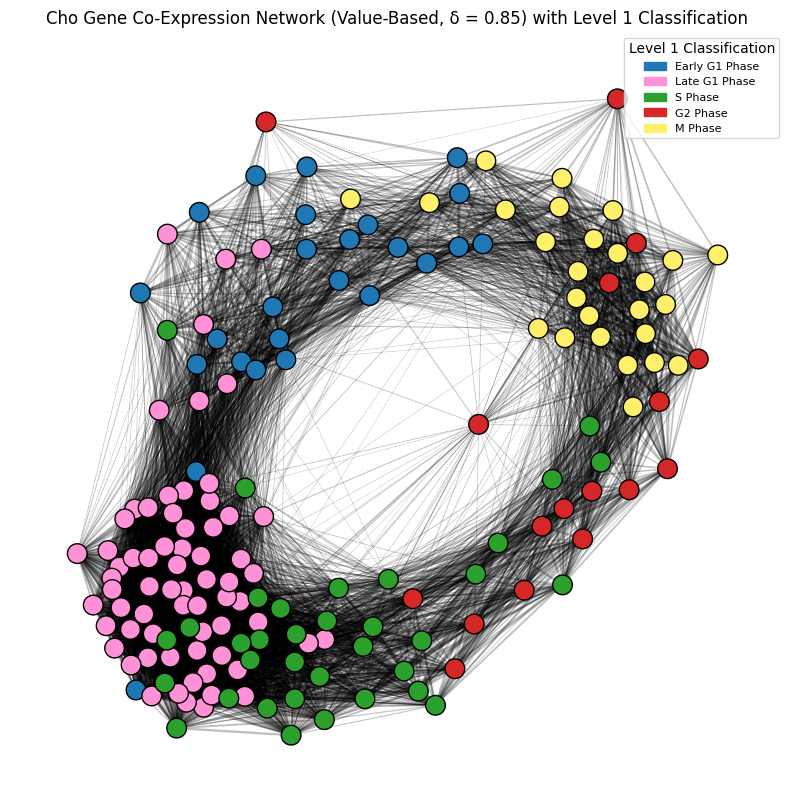

In [36]:
TABLEAU_COLORS = {
    'tab:blue': '#1f77b4',
    'tab:pink': '#ff91d7',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:yellow': '#fff06b',
}
# Define unique colors for each Level 1 classification
unique_classes = level_1_classes.unique()
color_map = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]] for i, cls in enumerate(unique_classes)}

# Assign colors to nodes based on Level 1 classification
node_colors = [color_map[G.nodes[n]["level_1"]] for n in G.nodes()]

# Edge weights for visualization (stronger edges appear tighter)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")
pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)  # Spring layout based on weights

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

# Draw edges with thickness based on weight
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
plt.title(f"Cho Gene Co-Expression Network (Value-Based, δ = {delta}) with Level 1 Classification")
plt.axis("off")
plt.show()

# Cho Network Visualization (Level 2 Classification)

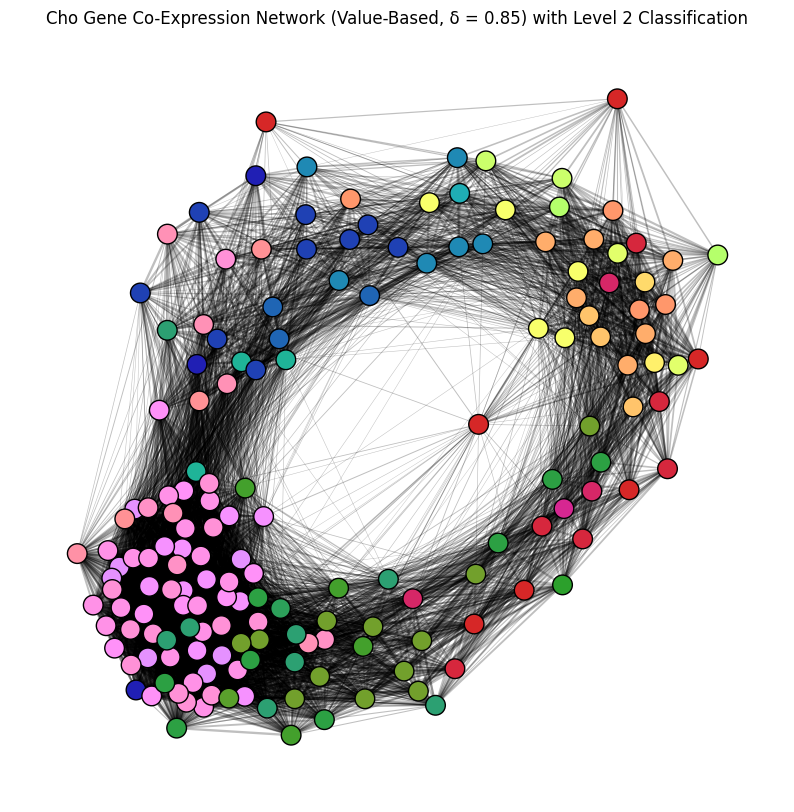

In [37]:
base_colors = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]]
               for i, cls in enumerate(unique_classes)}

# Function to generate distinct but related colors for Level 2 classifications
def generate_hue_variations(base_color, num_shades):
    """Generate distinct hues within a color family using HSL space."""
    base_rgb = mcolors.to_rgb(base_color)
    base_hls = colorsys.rgb_to_hls(*base_rgb)
    
    # Create variations by adjusting only the HUE component
    hues = np.linspace(base_hls[0] - 0.1, base_hls[0] + 0.1, num_shades)
    hues = np.clip(hues, 0, 1)  # Ensure hues are within valid range
    
    return [mcolors.to_hex(colorsys.hls_to_rgb(hue, base_hls[1], base_hls[2])) for hue in hues]

# Generate Level 2 colors based on hue variations within the Level 1 color family
level_2_groups = df.groupby("Level_1")["Level_2"].unique()
level_2_colors = {}

for lvl1, lvl2_values in level_2_groups.items():
    shades = generate_hue_variations(base_colors[lvl1], len(lvl2_values))
    for idx, lvl2 in enumerate(lvl2_values):
        level_2_colors[lvl2] = shades[idx]

# Assign colors to nodes based on Level 2 classification
node_colors_level_2 = [level_2_colors[G.nodes[n]["level_2"]] for n in G.nodes()]

# Edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
legend_handles_lvl2 = [Patch(color=color, label=f'Level 2: {cls}') for cls, color in level_2_colors.items()]
# plt.legend(handles=legend_handles_lvl2, loc="best", fontsize=6, title="Classification Hierarchy")

pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors_level_2, node_size=200, alpha=1, edgecolors="black")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
plt.title(f"Cho Gene Co-Expression Network (Value-Based, δ = {delta}) with Level 2 Classification")
plt.axis("off")
plt.show()


# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [7]:
def visualize_community(G, communities, title, output_dir, file_name, save_file=False):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Recalculate layout to ensure all nodes are included

    cmap = plt.get_cmap('viridis', len(communities))

    for i, community in enumerate(communities):
        if community:  # Check if community is not empty
            # Filter out nodes not present in the graph
            valid_nodes = [node for node in community if node in G]
            nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_color=[cmap(i)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    legend_handles = [mpatches.Patch(color=cmap(i), label=f'Community {i + 1}') for i in range(len(communities))]
    plt.legend(handles=legend_handles, loc='upper left', title="Communities")
    plt.title(f"{title} Algorithm Communities")
    plt.axis('off')
    plt.tight_layout()
    if save_file:
        plt.savefig(f"{output_dir}/{file_name}_{title}.png", bbox_inches="tight")
    plt.show()

In [8]:


def visualize_disconnected_communities(G, communities, color_map, title="Paris Algorithm Communities"):
    """
    Visualizes detected communities as separate disconnected subgraphs while keeping Level 1 colors.

    Parameters:
    - G: NetworkX graph
    - communities: CDLib NodeClustering object (Paris, Infomap, Louvain, etc.)
    - color_map: Dictionary mapping Level 1 categories to colors
    - title: Title for the plot
    """

    # Define layout positioning for separate communities
    num_communities = len(communities.communities)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate separate layouts for each community
    layouts = []
    for i in range(num_communities):
        layouts.append(nx.spring_layout(G.subgraph(communities.communities[i]), seed=42))

    # Normalize layout positions to avoid overlap
    spacing = 3
    for i, layout in enumerate(layouts):
        for node in layout:
            layout[node] += [i * spacing, 0]  # Shift positions to separate communities

    # Draw each community separately
    for i, community in enumerate(communities.communities):
        subG = G.subgraph(community)
        pos = layouts[i]

        # Assign Level 1 colors
        node_colors = [color_map[G.nodes[n]["level_1"]] for n in subG.nodes()]

        # Draw nodes
        nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

        # Draw edges
        nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color="black")

    # Create a legend for Level 1 classification
    cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
    legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")

    # Display
    plt.title(title)
    plt.axis("off")
    plt.show()


In [9]:
import itertools

def modified_rand_score(labels_true, labels_pred, nodes_true_list, nodes_pred_list):
    """
    Compute the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.

    Parameters
    ----------
    labels_true : list
        True labels corresponding to the nodes.
    labels_pred : list
        Predicted labels corresponding to the nodes.
    nodes_true_list : list
        An ordered list of nodes corresponding to labels_true.
    nodes_pred_list : list
        An ordered list of nodes corresponding to labels_pred.

    Returns
    -------
    mri : float
        The Modified Rand Index score.
    """

    n = len(labels_true)
    total_pairs = n * (n - 1) // 2  # All possible unique node pairs
    n_00, n_11, n_xx = 0, 0, 0  # Initialize counts

    # Convert lists to sets for fast lookup
    nodes_true_set = set(nodes_true_list)
    nodes_pred_set = set(nodes_pred_list)

    # Identify common nodes between the two partitions
    common_nodes = nodes_true_set.intersection(nodes_pred_set)

    # Iterate over all node pairs
    for i, j in itertools.combinations(range(n), 2):  # Iterate over all unique pairs
        node_i, node_j = nodes_true_list[i], nodes_true_list[j]

        # If either node is missing from the common set, count this pair as n_xx.
        if node_i not in common_nodes or node_j not in common_nodes:
            n_xx += 1
        else:
            same_true = (labels_true[i] == labels_true[j])
            same_pred = (labels_pred[i] == labels_pred[j])
            if same_true and same_pred:
                n_11 += 1  # Agreeing pair (same in both)
            elif not same_true and not same_pred:
                n_00 += 1  # Agreeing pair (different in both)

    # Compute MRI Score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI


# Hierarchical Community Detection

Using our formed network, we employ the Paris and LFM algorithms.

## Paris Algorithm

In [21]:
paris_communities = algorithms.paris(G)

def evaluate_paris():
	# Compute required metrics
	num_communities = len(paris_communities.communities)
	largest_community_size = max(len(c) for c in paris_communities.communities)
	community_sizes = [len(c) for c in paris_communities.communities]
	num_singletons = sum(1 for c in paris_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, paris_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(paris_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]

	node_to_community = {node: idx for idx, community in enumerate(paris_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in paris_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Paris_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [paris_communities.communities]
	})
	return Paris_results
Paris_results = evaluate_paris()
# output_dir = "Paris - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Paris_results.to_csv(f"{output_dir}/Paris_Results_Cho.csv")
Paris_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,3,76,"[76, 65, 29]",0,0.321865,0.63692,0.380619,0.08813,0.730386,0.651862,0.730386,0.651862,"[[112, 63, 100, 78, 53, 125, 49, 115, 31, 102,..."


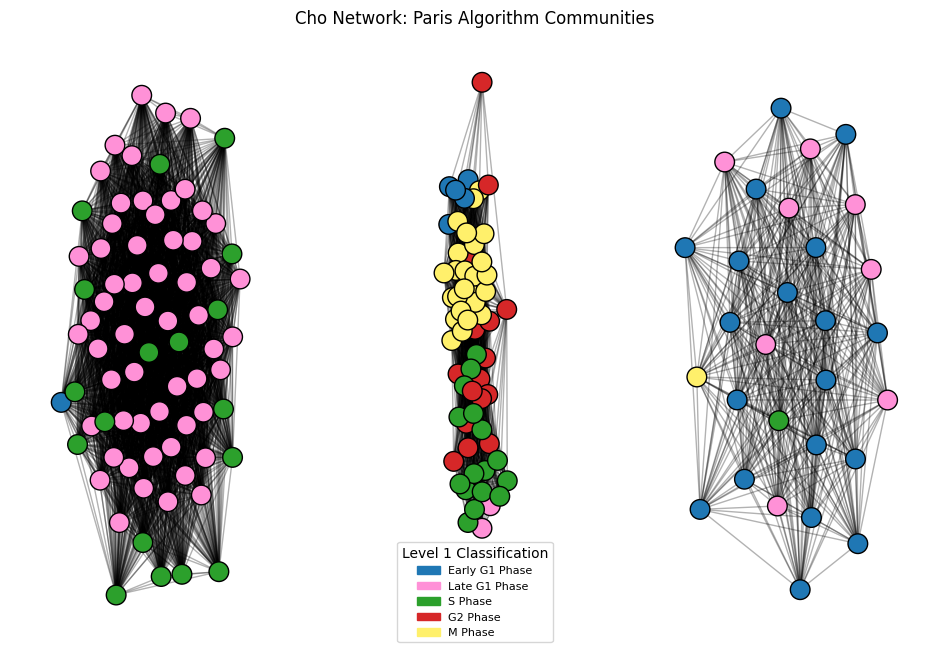

In [22]:
visualize_disconnected_communities(G, paris_communities, color_map, title="Cho Network: Paris Algorithm Communities")

## LFM Algorithm

In [30]:
random.seed(42)
np.random.seed(42)
# test value of alpha = 0.9
lfm_alpha = 0.9
lfm_communities = algorithms.lfm(G, alpha=lfm_alpha)

def evaluate_lfm():
	# Compute required metrics
	num_communities = len(lfm_communities.communities)
	largest_community_size = max(len(c) for c in lfm_communities.communities)
	community_sizes = [len(c) for c in lfm_communities.communities]
	num_singletons = sum(1 for c in lfm_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, lfm_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	node_counts = {}
	for i, community in enumerate(lfm_communities.communities):
			for node in community:
					if node not in node_counts:
							node_counts[node] = []
					node_counts[node].append(i)

	# Assign each node to the **smallest indexed** community it appears in
	predicted_labels_dict = {node: min(communities) for node, communities in node_counts.items()}

	# Create the final predicted labels list
	predicted_labels = [predicted_labels_dict[n] for n in G.nodes()]

	node_to_community = {node: idx for idx, community in enumerate(lfm_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in lfm_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	LFM_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [lfm_communities.communities]
	})
	return LFM_results

LFM_results = evaluate_lfm()
# output_dir = "LFM - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# LFM_results.to_csv(f"{output_dir}/LFM_results_Cho.csv")
LFM_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,5,170,"[170, 77, 77, 77, 77]",0,0.311106,0.63692,0.0,0.0,0.248312,0.040167,0.248312,0.040167,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


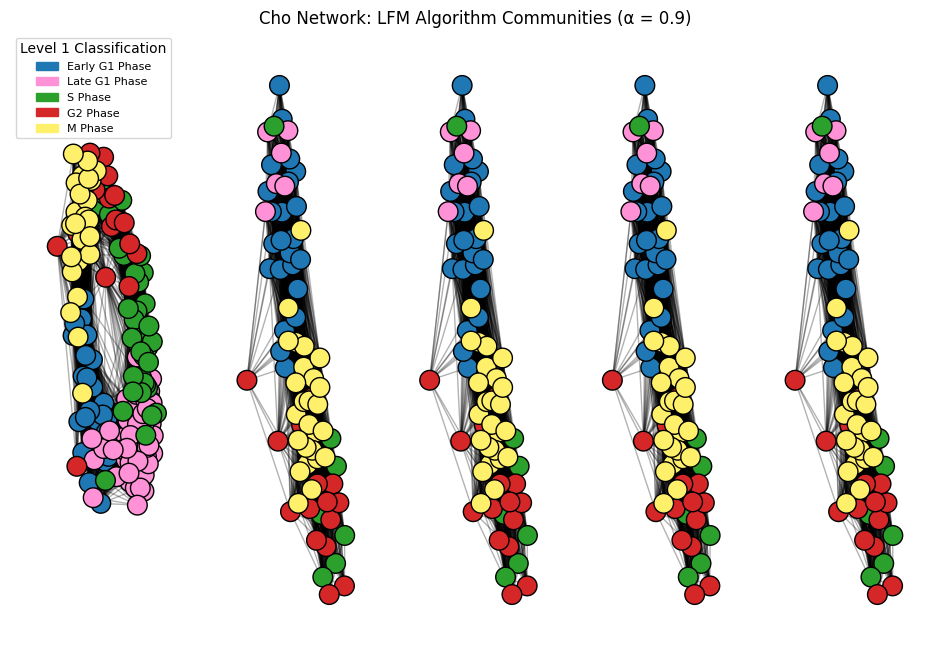

In [31]:
visualize_disconnected_communities(G, lfm_communities, color_map, title=f"Cho Network: LFM Algorithm Communities (α = {lfm_alpha})")

## Girvan Newman Algorithm

In [43]:
# level = 3 is best according to previous studies
gn_level = 3
gn_communities = algorithms.girvan_newman(G, level=gn_level)
def evaluate_gn():
	# Compute required metrics
	num_communities = len(gn_communities.communities)
	largest_community_size = max(len(c) for c in gn_communities.communities)
	community_sizes = [len(c) for c in gn_communities.communities]
	num_singletons = sum(1 for c in gn_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, gn_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(gn_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]

	node_to_community = {node: idx for idx, community in enumerate(gn_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in gn_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	GN_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [gn_communities.communities]
	})
	return GN_results

GN_results = evaluate_gn()
# output_dir = "LFM - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# GN_results.to_csv(f"{output_dir}/GN_results_Cho.csv")
GN_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,4,112,"[112, 56, 1, 1]",2,0.246489,0.63692,0.339462,0.050705,0.656457,0.490498,0.656457,0.490498,"[[0, 1, 2, 5, 11, 12, 14, 16, 17, 18, 22, 24, ..."


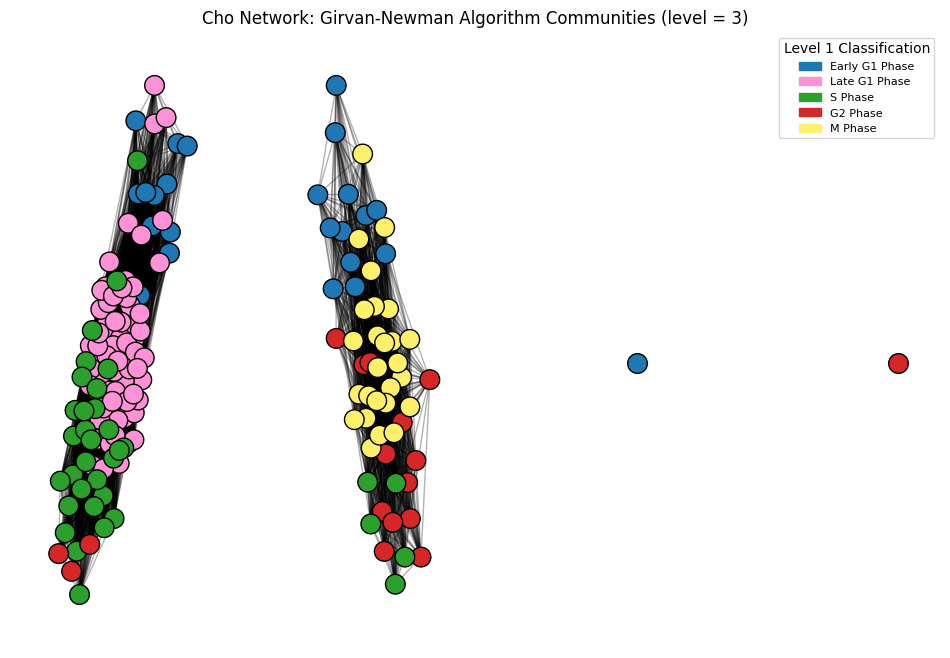

In [44]:
visualize_disconnected_communities(G, gn_communities, color_map, title=f"Cho Network: Girvan-Newman Algorithm Communities (level = {gn_level})")

# Dynamic Community Detection
Using our formed network, we employ the Infomap and TILES algorithms.

## Infomap Algorithm

In [16]:
infomap_communities = algorithms.infomap(G)

def evaluate_infomap():
	# Compute required metrics
	num_communities = len(infomap_communities.communities)
	largest_community_size = max(len(c) for c in infomap_communities.communities)
	community_sizes = [len(c) for c in infomap_communities.communities]
	num_singletons = sum(1 for c in infomap_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, infomap_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(infomap_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(infomap_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in infomap_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Infomap_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [infomap_communities.communities]
	})
	return Infomap_results

Infomap_results = evaluate_infomap()
# output_dir = "Infomap - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Infomap_results.to_csv(f"{output_dir}/Infomap_results_Cho.csv")
Infomap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,2,110,"[110, 60]",0,0.258223,0.63692,0.339461,0.051593,0.656248,0.490428,0.656248,0.490428,"[[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,..."


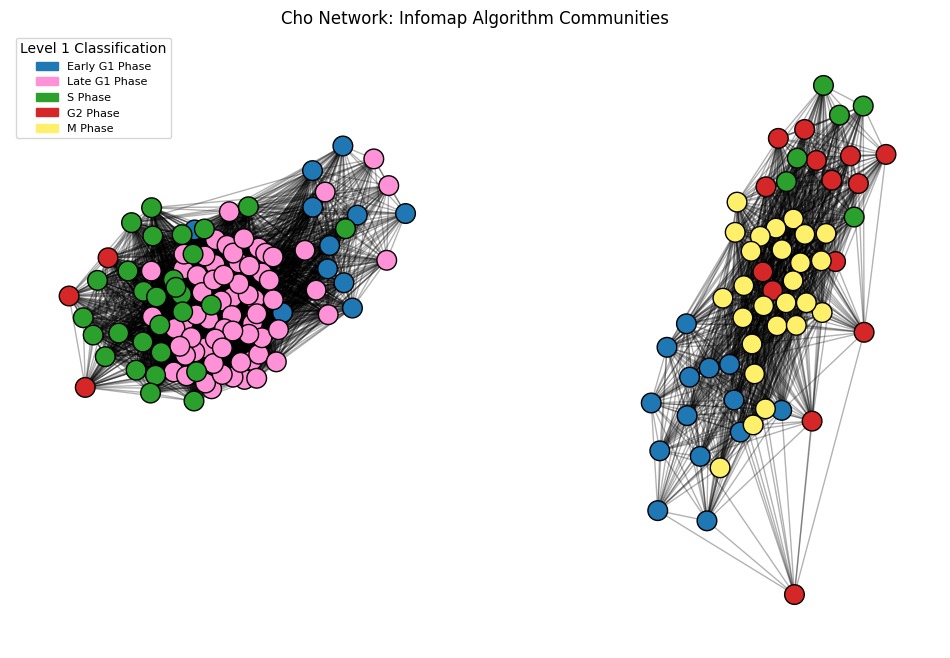

In [17]:
visualize_disconnected_communities(G, infomap_communities, color_map, title="Cho Network: Infomap Algorithm Communities")

## Walktrap Algorithm

In [ ]:
walktrap_communities = algorithms.walktrap(G)

def evaluate_walktrap():
	# Compute required metrics
	num_communities = len(walktrap_communities.communities)
	largest_community_size = max(len(c) for c in walktrap_communities.communities)
	community_sizes = [len(c) for c in walktrap_communities.communities]
	num_singletons = sum(1 for c in walktrap_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, walktrap_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(walktrap_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(walktrap_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in walktrap_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Walktrap_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [walktrap_communities.communities]
	})
	return Walktrap_results

Walktrap_results = evaluate_walktrap()
# output_dir = "Walktrap - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Walktrap_results.to_csv(f"{output_dir}/Walktrap_results_Cho.csv")
Walktrap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,2,108,"[108, 62]",0,0.262891,0.63692,0.333548,0.052677,0.655412,0.496833,0.655412,0.496833,"[[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,..."


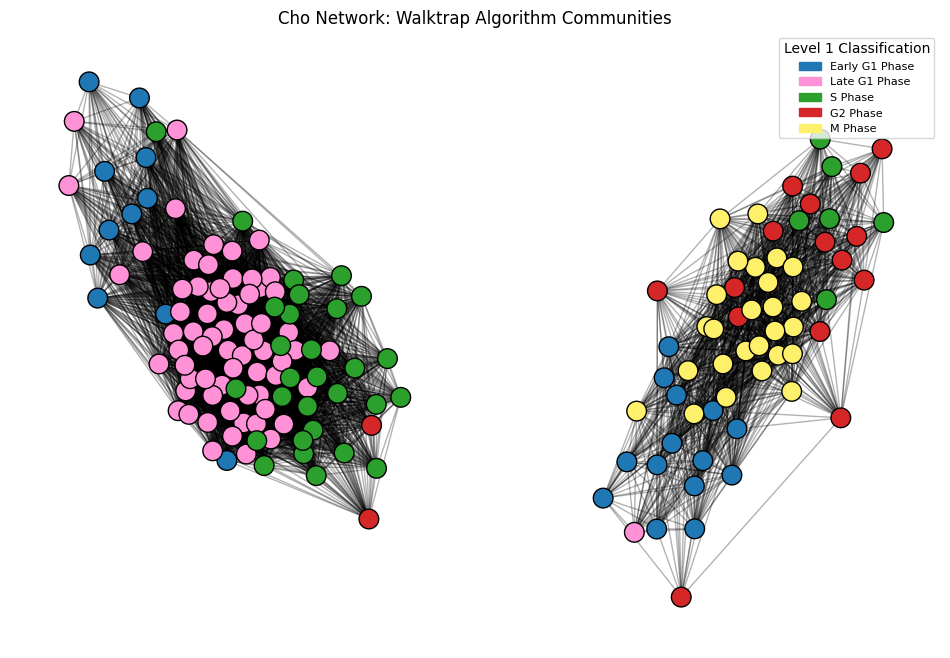

In [24]:
visualize_disconnected_communities(G, walktrap_communities, color_map, title="Cho Network: Walktrap Algorithm Communities")

## Spinglass Algorithm

In [ ]:
spinglass_communities = algorithms.spinglass(G)

def evaluate_spinglass():
	# Compute required metrics
	num_communities = len(spinglass_communities.communities)
	largest_community_size = max(len(c) for c in spinglass_communities.communities)
	community_sizes = [len(c) for c in spinglass_communities.communities]
	num_singletons = sum(1 for c in spinglass_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, spinglass_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(spinglass_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(spinglass_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in spinglass_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Spinglass_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"Communities": [spinglass_communities.communities]
	})
	return Spinglass_results

Spinglass_results = evaluate_spinglass()
# output_dir = "Spinglass - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Spinglass_results.to_csv(f"{output_dir}/Spinglass_results_Cho.csv")
Spinglass_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,4,92,"[92, 76, 1, 1]",2,0.311083,0.63692,0.311694,0.060838,0.65938,0.539227,0.65938,0.539227,"[[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3..."


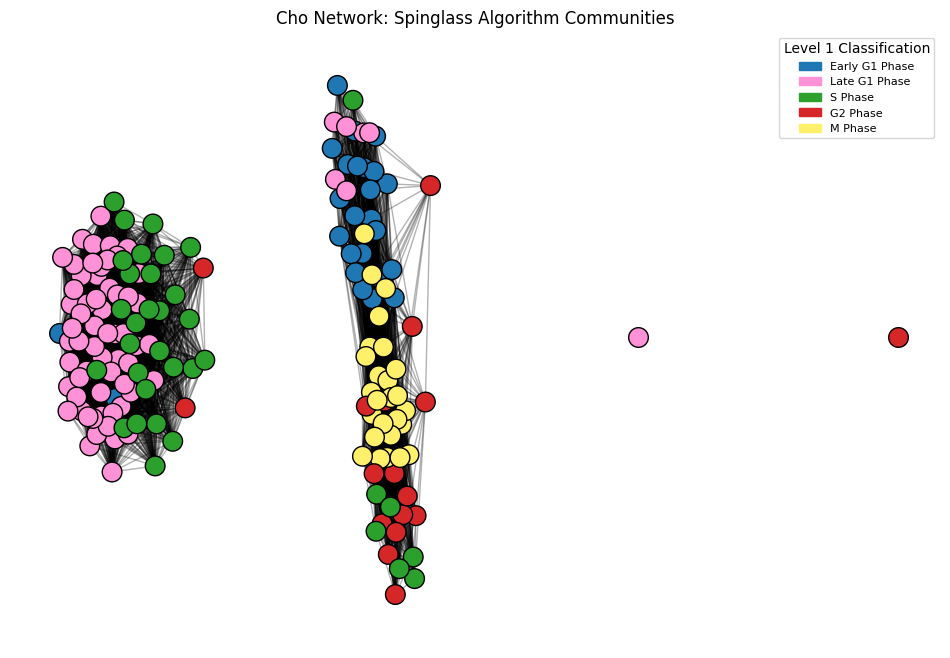

In [48]:
visualize_disconnected_communities(G, spinglass_communities, color_map, title="Cho Network: Spinglass Algorithm Communities")

## TILES Algorithm

In [19]:
print("TILES!")

TILES!


# Community Detection Results

In [50]:
Community_Detection_Results = pd.concat([Paris_results, LFM_results, GN_results, Infomap_results, Walktrap_results, Spinglass_results], axis=0)
Community_Detection_Results.index = ["Paris", "LFM", "Girvan-Newman", "Infomap", "Walktrap", "Spinglass"]

output_dir = "Community Detection Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
Community_Detection_Results.to_csv(f"{output_dir}/Cho_Communities.csv")

Community_Detection_Results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
Paris,3,76,"[76, 65, 29]",0,0.321865,0.63692,0.380619,0.088130,0.730386,0.651862,0.730386,0.651862,"[[112, 63, 100, 78, 53, 125, 49, 115, 31, 102,..."
LFM,5,170,"[170, 77, 77, 77, 77]",0,0.311106,0.63692,0.000000,0.000000,0.248312,0.040167,0.248312,0.040167,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
Girvan-Newman,4,112,"[112, 56, 1, 1]",2,0.246489,0.63692,0.339462,0.050705,0.656457,0.490498,0.656457,0.490498,"[[0, 1, 2, 5, 11, 12, 14, 16, 17, 18, 22, 24, ..."
Infomap,2,110,"[110, 60]",0,0.258223,0.63692,0.339461,0.051593,0.656248,0.490428,0.656248,0.490428,"[[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,..."
Walktrap,2,108,"[108, 62]",0,0.262891,0.63692,0.333548,0.052677,0.655412,0.496833,0.655412,0.496833,"[[0, 1, 2, 11, 12, 16, 17, 18, 20, 22, 24, 25,..."
Spinglass,4,92,"[92, 76, 1, 1]",2,0.311083,0.63692,0.311694,0.060838,0.659380,0.539227,0.659380,0.539227,"[[2, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3..."
